<a href="https://colab.research.google.com/github/siahkamari19/Multi-Label-Classification-on-a-large-date-base-from-SQL-query/blob/main/311.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applicant : Mohammad Siahkamari 

# **MultiClass Classification on 311 New York complaint calls**
 
In this project I have designed a MultiClass classification task on the data with various algorithms along with data visualization to better understand the data and coloration between the features and the classes.
 
The algorithms used for this project are as follows:
 
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. K Nearest Neighbors
5. Support Vector Classifier
6. Ada Boost
7. Gradient Boost
8. Extreme Gradient Boost
9. Naive Bayes
10. Neural Network
 
The features and the amount of data have been selected based on computation power limitation, intuition, trial/error on all the algorithms above, the best features to classify 60 classes from most common complaints which have been randomly selected from all of the dataset to sample 25000 data points are as follow:
 
1. incident_zip
2. location_type
3. created_date
4. agency
5. latitude
6. longitude
7. descriptor
 
The Neural Network Sequential model has been tuned manually on all the scenarios since I couldn't run grid search for fine tuning the hyperparameters.
 
With the amount of data that I have I could run the algorithm only once after OneHotEncoding the data for NN Model.
 
The hidden layers, layer size, learning rate, dropout rate, batch size and epochs are all tried in all combinations with respect to the 5 fold validation scores to get the best ones.
 
 
The answers to the Challenge One: Data Analysis are as follow:
 
#1. How many incidents were opened in each year (beginning with 2010)? 2. Which borough has the most incidents?
 
After running the query a to get some relevant columns for visualization and challenge one I observed that how many incidents were opened in each year and the response is in the bar chart below:


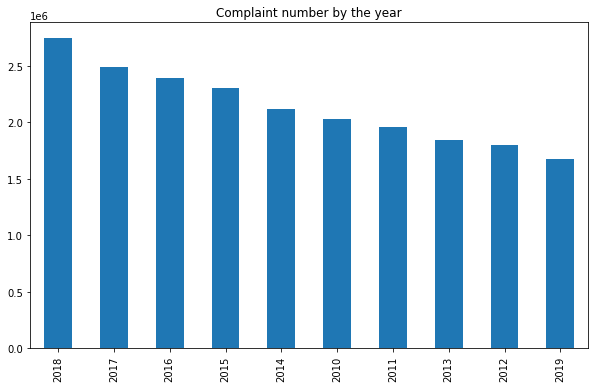

#2. Which borough has the most incidents?

Brooklyn is the borough with the most complaints after counting all the complaints in each borough.

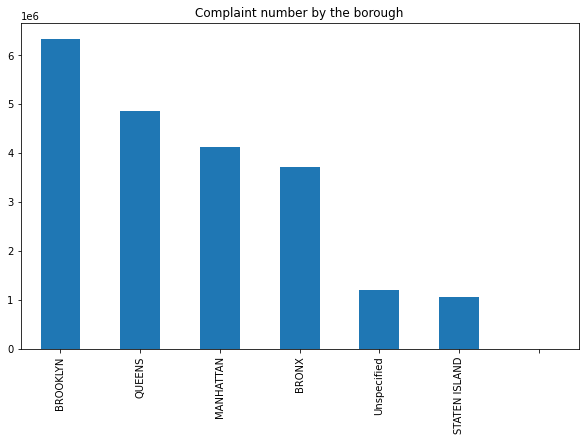

The code has been provided in the notebook below. First we do a query to visualize the data and answer the first two questions then we do another query for the classification task and start preprocessing the data and designing the models.

#Importing all the necessary libraries

In [ ]:
import psycopg2
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error, f1_score
%matplotlib inline


def query_db(query):
  '''
  Runs sql query on 311 database and returns a pandas DataFrame.
  Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the same
  '''
  host = 'interview-ds.ckgnwnm6pw4o.us-east-1.redshift.amazonaws.com'
  port = 5439
  db = 'interview'
  username = 'dsguest'
  password = 'nX9EFYUZ5Yu#0q'
  conn = psycopg2.connect(host=host, port=port, dbname=db, user=username, password=password)
  cur = conn.cursor()
  cur.execute(query)
  rows = cur.fetchall()
  rows = pd.DataFrame(rows)
  return rows


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#The query to select columns needed to better understand the data and visualization purposes

In [ ]:
a = query_db("SELECT created_date, complaint_type, borough, location_type, agency, incident_zip FROM public.three_one_one;")
a.rename(columns={0: 'created_date', 1: 'complaint_type', 2: 'borough', 3:'location_type', 4:'agency', 5:'incident_zip'}, inplace=True)

A function to drop all the NAN from data and counting the values of each columns

In [ ]:
def getDfSummary(input_data):
    number_nan = input_data.isnull().sum()
    number_distinct = input_data.nunique(dropna=True)
    output_data = pd.DataFrame({'number_nan':number_nan,'number_distinct':number_distinct})
    return output_data

getDfSummary(a)

,number_nan,number_distinct
created_date,0,13931767
complaint_type,0,433
borough,0,7
location_type,0,171
agency,0,31
incident_zip,1275612,2355


Changing the created date column to 3 columns of year, month and our to better help with the task and also count the complaints in each year.

In [ ]:
a['hour'] = a['created_date'].dt.hour
a['month'] = a['created_date'].dt.month
a['year'] = a['created_date'].dt.year
a = a.drop(columns=['created_date'])
a['year'].value_counts()

2018    2747985
2017    2491969
2016    2391426
2015    2300760
2014    2114000
2010    2031813
2011    1961598
2013    1839974
2012    1796207
2019    1675384
Name: year, dtype: int64

# Data Visualization

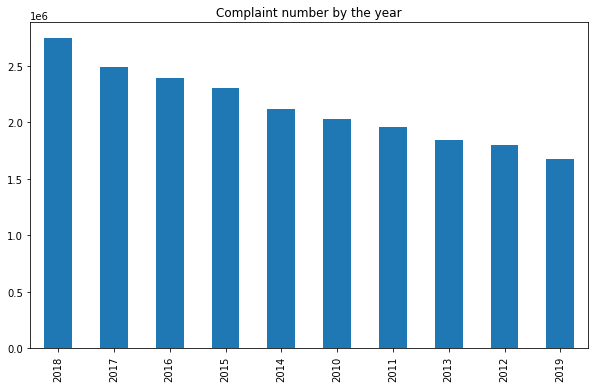

In [ ]:
(a['year'].value_counts()).head(10).plot(kind='bar', figsize=(10,6), title = 'Complaint number by the year')
plt.show()

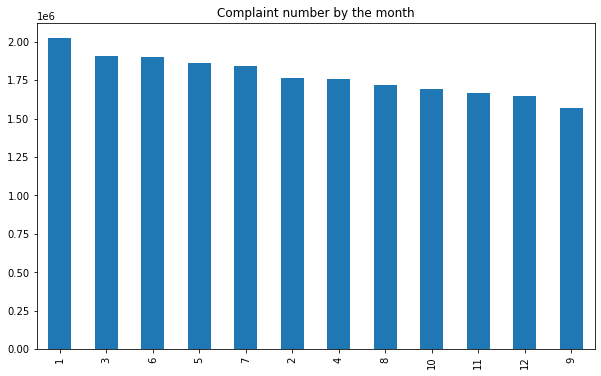

In [ ]:
(a['month'].value_counts()).head(12).plot(kind='bar', figsize=(10,6), title = 'Complaint number by the month')
plt.show()

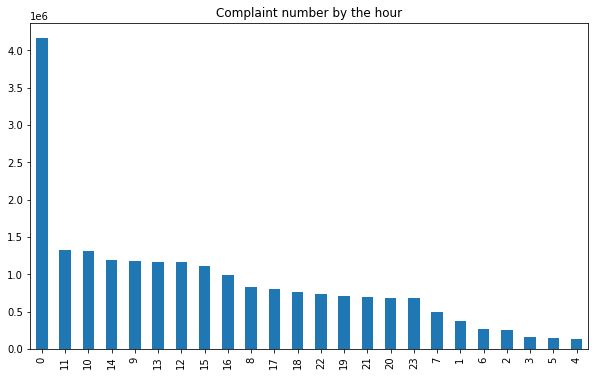

In [ ]:
(a['hour'].value_counts()).head(24).plot(kind='bar', figsize=(10,6), title = 'Complaint number by the hour')
plt.show()

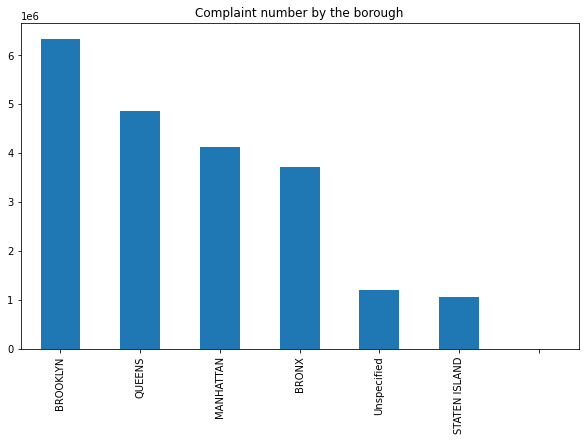

BROOKLYN         6342836
QUEENS           4865070
MANHATTAN        4134900
BRONX            3718699
Unspecified      1218678
STATEN ISLAND    1070930
                       3
Name: borough, dtype: int64

In [ ]:
(a['borough'].value_counts()).head(7).plot(kind='bar', figsize=(10,6), title = 'Complaint number by the borough')
plt.show()
a['borough'].value_counts()

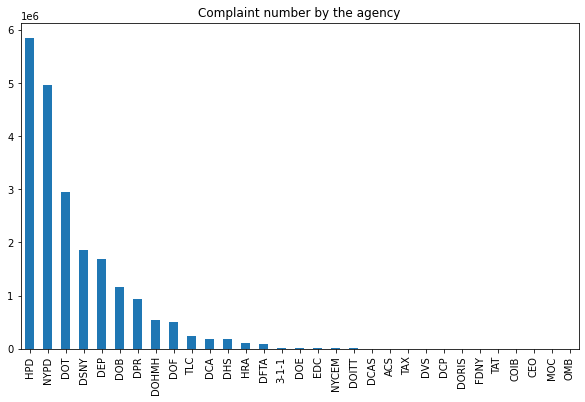

In [ ]:
(a['agency'].value_counts()).head(50).plot(kind='bar', figsize=(10,6), title = 'Complaint number by the agency')
plt.show()

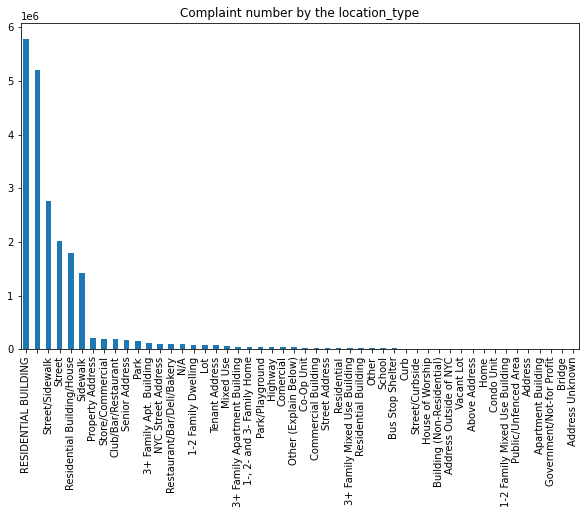

In [ ]:
(a['location_type'].value_counts()).head(50).plot(kind='bar', figsize=(10,6), title = 'Complaint number by the location_type')
plt.show()

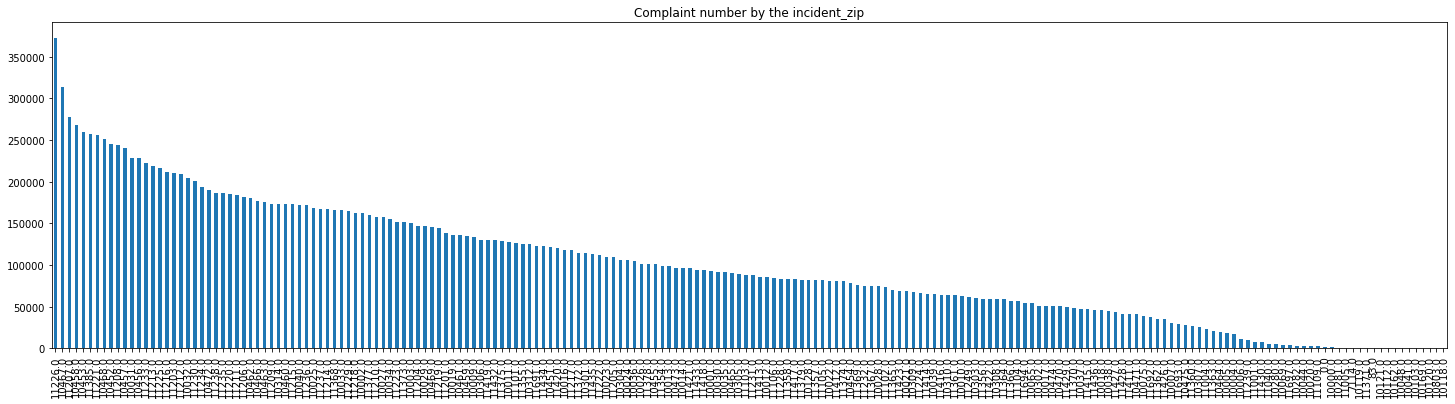

In [ ]:
(a['incident_zip'].value_counts()).head(200).plot(kind='bar', figsize=(25,6), title = 'Complaint number by the incident_zip')
plt.show()

Below I understood that about 60 first most common complaints would be a lot more frequent than rest of the classes

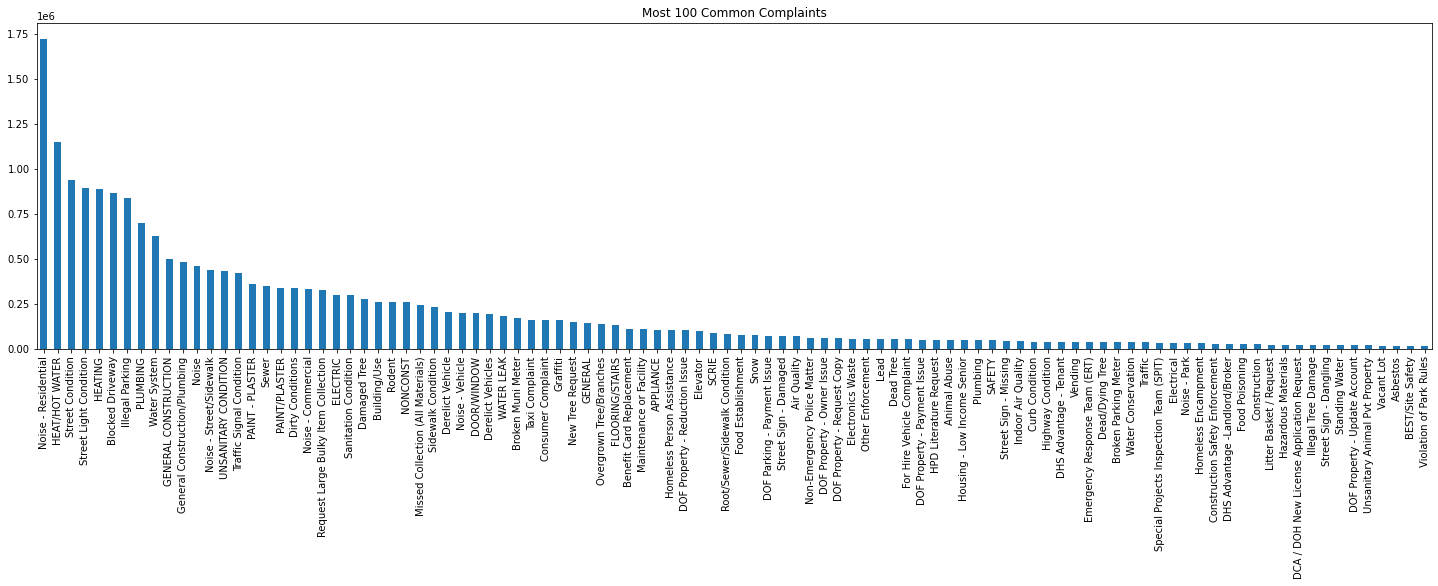

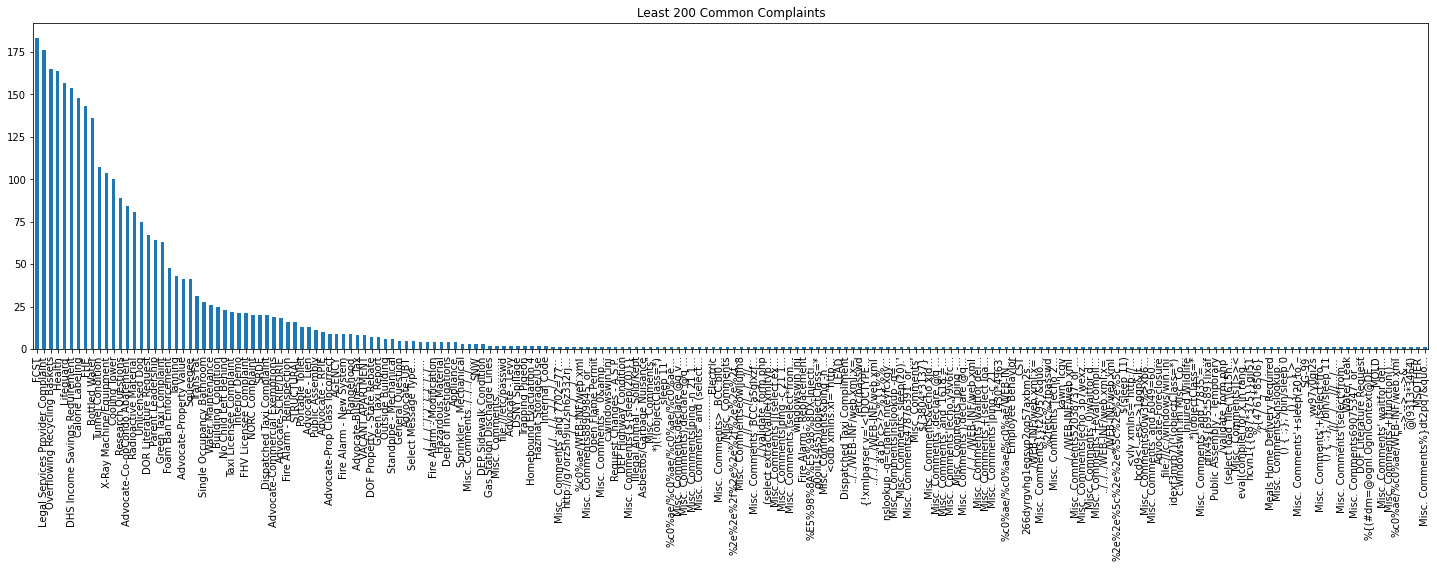

Noise - Residential                    1722501
HEAT/HOT WATER                         1149728
Street Condition                        939603
Street Light Condition                  891730
HEATING                                 887869
Blocked Driveway                        867920
Illegal Parking                         839945
PLUMBING                                701818
Water System                            630164
GENERAL CONSTRUCTION                    500863
General Construction/Plumbing           482615
Noise                                   461147
Noise - Street/Sidewalk                 439857
UNSANITARY CONDITION                    434264
Traffic Signal Condition                420676
PAINT - PLASTER                         361258
Sewer                                   351446
PAINT/PLASTER                           340574
Dirty Conditions                        337505
Noise - Commercial                      335344
Request Large Bulky Item Collection     326335
ELECTRIC     

In [ ]:
(a['complaint_type'].value_counts()).head(100).plot(kind='bar', figsize=(25,6), title = 'Most 100 Common Complaints')
plt.show()
(a['complaint_type'].value_counts()).tail(200).plot(kind='bar', figsize=(25,6), title = 'Least 200 Common Complaints')
plt.show()
b=a['complaint_type'].value_counts()
b.head(50)

#Preprocessing 

The query to select our best features and classes for the task with respect to the limitations:
 
1. The rows should have been selected from the complaints that are occurring more than 50000 times in the database
 
2. The rows should not include NAN(I only put the limit on those rows that had lots of NAN)
 
3. And the have to be selected randomly so that we avoid bias as much as it is possible

Second line would name the columns that have been selected from the database

In [ ]:
df= query_db("SELECT complaint_type, incident_zip, location_type, created_date, agency, latitude, longitude, descriptor FROM public.three_one_one WHERE complaint_type IN (SELECT complaint_type FROM public.three_one_one GROUP BY complaint_type HAVING COUNT(*)>50000) AND incident_zip IS NOT NULL AND descriptor IS NOT NULL AND latitude IS NOT NULL AND longitude IS NOT NULL ORDER BY RAND() LIMIT 25000;")
df.rename(columns={0: 'complaint_type', 1: 'incident_zip', 2:'location_type', 3:'created_date', 4:'agency', 5:'latitude', 6:'longitude', 7: 'descriptor'}, inplace=True)


Printing out all the columns values

In [ ]:
for i in df.columns:
  print(i,df[i].unique())

complaint_type ['Overgrown Tree/Branches' 'Street Light Condition' 'HEATING' 'PLUMBING'
 'Request Large Bulky Item Collection' 'Noise - Street/Sidewalk'
 'Illegal Parking' 'PAINT/PLASTER' 'Air Quality' 'Street Condition'
 'Water System' 'Missed Collection (All Materials)' 'Sewer' 'NONCONST'
 'PAINT - PLASTER' 'Noise - Vehicle' 'Consumer Complaint'
 'Noise - Residential' 'APPLIANCE' 'DOOR/WINDOW' 'Lead' 'Blocked Driveway'
 'Taxi Complaint' 'HEAT/HOT WATER' 'Sanitation Condition' 'Noise'
 'General Construction/Plumbing' 'Non-Emergency Police Matter'
 'Damaged Tree' 'Traffic Signal Condition' 'Sidewalk Condition'
 'WATER LEAK' 'GENERAL CONSTRUCTION' 'Rodent' 'Dirty Conditions'
 'Animal Abuse' 'Building/Use' 'UNSANITARY CONDITION' 'Derelict Vehicles'
 'Dead Tree' 'Noise - Commercial' 'Root/Sewer/Sidewalk Condition'
 'GENERAL' 'Derelict Vehicle' 'Maintenance or Facility'
 'Street Sign - Damaged' 'New Tree Request' 'Broken Muni Meter' 'ELECTRIC'
 'FLOORING/STAIRS' 'Graffiti' 'Homeless Person

#Data Normalization 

Normalizing the column created_date from date to year, month, hour and label encoding the rest of the columns since they are all categorical.



In [ ]:
df['hour'] = df['created_date'].dt.hour
df['month'] = df['created_date'].dt.month
df['year'] = df['created_date'].dt.year
df = df.drop(columns=['created_date'])

l1 = LabelEncoder()
l2 = LabelEncoder()
l3 = LabelEncoder()
l4 = LabelEncoder()
l5 = LabelEncoder()
l6 = LabelEncoder()
l7 = LabelEncoder()

df['complaint_type'] = l7.fit_transform(df['complaint_type'])
df['incident_zip'] = l1.fit_transform(df['incident_zip'])
df['location_type'] = l2.fit_transform(df['location_type'])
df['agency'] = l3.fit_transform(df['agency'])
df['latitude'] = l4.fit_transform(df['latitude'])
df['longitude'] = l5.fit_transform(df['longitude'])
df['descriptor'] = l6.fit_transform(df['descriptor'])

Counting the classes and visualization

In [ ]:
len(df['complaint_type'].value_counts())

60

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


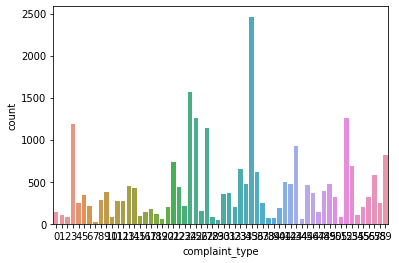

In [ ]:
sns.countplot(df['complaint_type'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


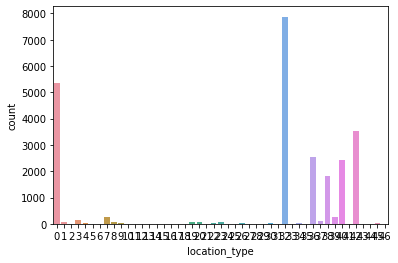

In [ ]:
sns.countplot(df['location_type'])

In [ ]:
def getDfSummary(input_data):
    number_nan = input_data.isnull().sum()
    number_distinct = input_data.nunique(dropna=True)
    output_data = pd.DataFrame({'number_nan':number_nan,'number_distinct':number_distinct})
    return output_data

getDfSummary(df)    

,number_nan,number_distinct
complaint_type,0,60
incident_zip,0,190
location_type,0,47
agency,0,12
latitude,0,22304
longitude,0,22304
descriptor,0,455
hour,0,24
month,0,12
year,0,10


In [ ]:
df.shape 

(25000, 10)

In [ ]:
df.dtypes

complaint_type    int64
incident_zip      int64
location_type     int64
agency            int64
latitude          int64
longitude         int64
descriptor        int64
hour              int64
month             int64
year              int64
dtype: object

In [ ]:
df

,complaint_type,incident_zip,location_type,agency,latitude,longitude,descriptor,hour,month,year
0,40,111,40,7,6222,9435,213,14,3,2015
1,53,162,0,6,9084,21984,399,10,6,2016
2,25,71,32,9,21164,15438,207,0,11,2010
3,43,119,32,9,8921,12871,343,0,2,2014
4,45,16,38,8,14123,5532,351,8,2,2018
...,...,...,...,...,...,...,...,...,...,...
24995,35,100,36,10,9554,4107,41,9,12,2018
24996,35,18,36,10,15307,3141,259,23,7,2018
24997,59,55,0,1,862,829,114,17,9,2017
24998,8,79,32,9,22019,17679,440,18,11,2018


In [ ]:
df.describe()

,complaint_type,incident_zip,location_type,agency,latitude,longitude,descriptor,hour,month,year
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,32.037640,95.998880,27.485760,7.637040,11420.26680,11166.758400,220.006880,10.530440,6.337440,2014.725680
std,16.059412,48.475147,15.651367,2.816895,6505.94191,6314.840931,127.616449,7.485861,3.473542,2.805242
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,2010.000000
25%,22.000000,64.000000,26.000000,6.000000,5712.75000,5825.750000,108.000000,2.000000,3.000000,2012.000000
50%,34.000000,103.000000,32.000000,9.000000,11482.50000,11170.500000,240.000000,11.000000,6.000000,2015.000000
75%,45.000000,131.000000,39.000000,10.000000,17253.25000,16571.250000,315.000000,16.000000,9.000000,2017.000000
max,59.000000,189.000000,46.000000,11.000000,22303.00000,22303.000000,454.000000,23.000000,12.000000,2019.000000


we can better visualize the correlation in color with. The lighter the color, the greater the correlation value.

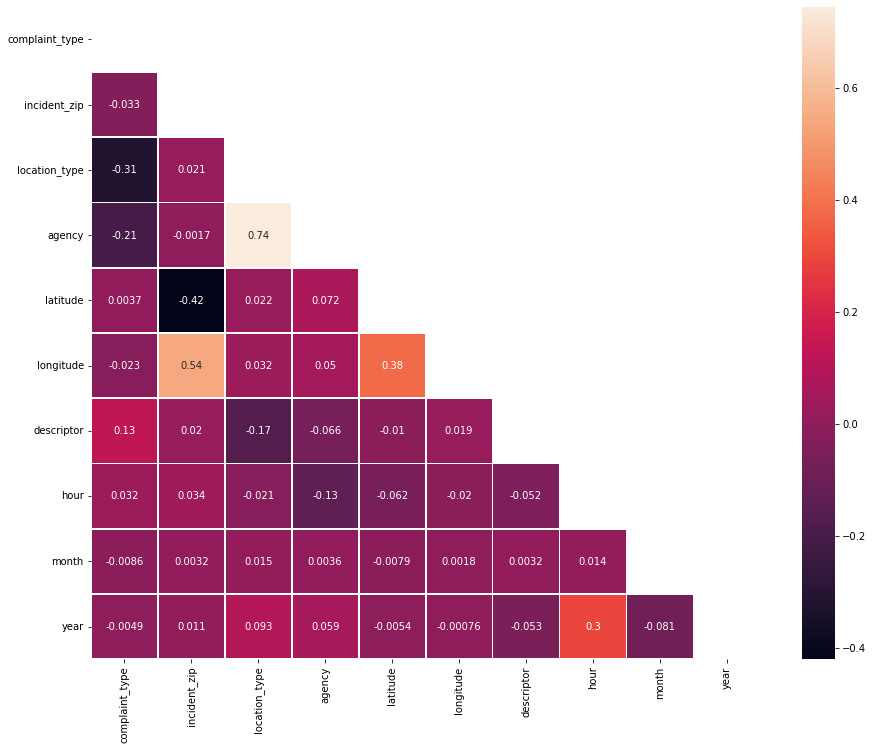

In [ ]:
plt.figure(figsize=(15, 12))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, linewidth=.8, mask=matrix, cmap="rocket");

Selecting columns from DataFrame for the classification task

In [ ]:
xc = df[['incident_zip','location_type', 'hour', 'year', 'month', 'agency', 'latitude', 'longitude', 'descriptor']]
print(xc.shape)

yc = df[['complaint_type']]
print(yc.shape)

xc_train, xc_test, yc_train, yc_test = train_test_split(xc,yc,test_size=0.3, random_state=0)
print(len(xc_train))
print(len(xc_test))
print(len(yc_train))
print(len(yc_test))

(25000, 9)
(25000, 1)
17500
7500
17500
7500


Spliting data to train and test

#Random forest and XGB classifier Model
 
These models have been selected among all the other models since they had the best performance and speed.
 
Random forest will behave better if we have 10000 data points and will give a 99% accuracy and XGB doing better on the 25000 data points but it is considerably slower.


In [ ]:
rfc = RandomForestClassifier()
xgb = XGBClassifier()
lrc = LogisticRegression()
dtc = DecisionTreeClassifier()
knn= KNeighborsClassifier(n_neighbors=7)
adb = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
gnb = GaussianNB()
svc = SVC()

clfs = {'dtc' :dtc, 'rfc':rfc,'xgb':xgb, 'lr' :lrc, 'knn' :knn, 'adb' :adb, 'gbc' :gbc, 'gnb' :gnb, 'svc' :svc}

xc = xc.to_numpy()
yc = np.array(yc)

models = ['dtc', 'rfc', 'xgb','lr', 'knn', 'adb', 'gbc', 'gnb', 'svc']
skf = StratifiedKFold(n_splits=5)
mean_acc = []

for model in models:
  acc = []

  for train_index, test_index in skf.split(xc, yc):
      xc_train, xc_test = xc[train_index], xc[test_index]
      yc_train, yc_test = yc[train_index], yc[test_index]
      clf= clfs[model]
      clf.fit(xc_train, yc_train)  
      yc_pred = clf.predict(xc_test)
      acc.append(accuracy_score(yc_test, yc_pred)*100)

  print(classification_report(yc_test,yc_pred))
  print(confusion_matrix(yc_test,yc_pred))
  print(f"The accuracy of the {model} Model is: {np.mean(acc)} %")
  mean_acc.append(np.mean(acc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21
           2       0.78      0.54      0.64        13
           3       1.00      1.00      1.00       248
           4       0.98      0.98      0.98        45
           5       0.97      1.00      0.99        73
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00        59
           9       1.00      1.00      1.00        77
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        48
          12       1.00      1.00      1.00        49
          13       0.97      0.99      0.98        92
          14       1.00      1.00      1.00        77
          15       1.00      1.00      1.00        18
          16       1.00      0.97      0.98        29
          17       1.00    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed whe

              precision    recall  f1-score   support

           0       0.93      0.45      0.60        29
           1       1.00      1.00      1.00        21
           2       0.70      0.54      0.61        13
           3       0.94      1.00      0.97       248
           4       0.96      1.00      0.98        45
           5       0.97      1.00      0.99        73
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00         3
           8       0.87      1.00      0.93        59
           9       0.94      1.00      0.97        77
          10       0.92      0.92      0.92        12
          11       1.00      1.00      1.00        48
          12       1.00      1.00      1.00        49
          13       0.87      1.00      0.93        92
          14       0.94      0.81      0.87        77
          15       1.00      1.00      1.00        18
          16       1.00      0.97      0.98        29
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21
           2       0.80      0.62      0.70        13
           3       1.00      1.00      1.00       248
           4       1.00      1.00      1.00        45
           5       0.97      1.00      0.99        73
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00        59
           9       1.00      1.00      1.00        77
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        48
          12       1.00      1.00      1.00        49
          13       0.98      1.00      0.99        92
          14       1.00      1.00      1.00        77
          15       1.00      1.00      1.00        18
          16       1.00      0.97      0.98        29
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        13
           3       0.10      0.28      0.15       248
           4       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        73
           6       0.00      0.00      0.00        41
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00        77
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00        48
          12       0.00      0.00      0.00        49
          13       0.00      0.00      0.00        92
          14       0.00      0.00      0.00        77
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        29
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

              precision    recall  f1-score   support

           0       0.03      0.07      0.04        29
           1       0.06      0.10      0.07        21
           2       0.03      0.08      0.05        13
           3       0.12      0.37      0.18       248
           4       0.04      0.09      0.06        45
           5       0.04      0.07      0.05        73
           6       0.01      0.02      0.02        41
           7       0.00      0.00      0.00         3
           8       0.07      0.07      0.07        59
           9       0.08      0.13      0.10        77
          10       0.00      0.00      0.00        12
          11       0.17      0.12      0.14        48
          12       0.12      0.10      0.11        49
          13       0.06      0.09      0.07        92
          14       0.01      0.01      0.01        77
          15       0.08      0.11      0.10        18
          16       0.03      0.03      0.03        29
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00       248
           4       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        73
           6       1.00      1.00      1.00        41
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00        77
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00        48
          12       0.00      0.00      0.00        49
          13       0.00      0.00      0.00        92
          14       0.00      0.00      0.00        77
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        29
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       1.00      1.00      1.00        21
           2       0.58      0.85      0.69        13
           3       0.95      1.00      0.98       248
           4       1.00      1.00      1.00        45
           5       0.97      1.00      0.99        73
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00        59
           9       1.00      1.00      1.00        77
          10       1.00      1.00      1.00        12
          11       1.00      0.98      0.99        48
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        92
          14       0.96      1.00      0.98        77
          15       1.00      1.00      1.00        18
          16       1.00      0.97      0.98        29
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       1.00      1.00      1.00        21
           2       0.00      0.00      0.00        13
           3       0.93      0.96      0.94       248
           4       0.44      0.80      0.57        45
           5       0.78      0.78      0.78        73
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00         3
           8       0.00      0.00      0.00        59
           9       0.57      0.05      0.10        77
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        48
          12       1.00      1.00      1.00        49
          13       0.74      0.76      0.75        92
          14       0.00      0.00      0.00        77
          15       1.00      1.00      1.00        18
          16       0.93      0.97      0.95        29
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00       248
           4       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        73
           6       0.00      0.00      0.00        41
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00        77
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00        48
          12       0.00      0.00      0.00        49
          13       0.00      0.00      0.00        92
          14       0.00      0.00      0.00        77
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        29
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
i = 0
for model in models:
  print(f"The accuracy of the {model} is: {mean_acc[i]}")
  i += 1

The accuracy of the dtc is: 98.748
The accuracy of the rfc is: 96.28
The accuracy of the xgb is: 99.056
The accuracy of the lr is: 10.680000000000001
The accuracy of the knn is: 11.7
The accuracy of the adb is: 14.483999999999998
The accuracy of the gbc is: 98.316
The accuracy of the gnb is: 67.94
The accuracy of the svc is: 9.7


Making a new data set for the Neural Network model and performing OneHotEncoding


In [ ]:
df['hour'] = df['created_date'].dt.hour
df['month'] = df['created_date'].dt.month
df['year'] = df['created_date'].dt.year
df = df.drop(columns=['created_date'])

xd = df[['incident_zip','location_type', 'hour', 'year', 'month', 'agency', 'latitude', 'longitude', 'descriptor']]
ohe = OneHotEncoder(sparse=False)
xd = ohe.fit_transform(xd)
print(xd.shape)

yd = df[['complaint_type']]
ohe = OneHotEncoder(sparse=False)
yd = ohe.fit_transform(df[['complaint_type']])
print(yd.shape)

xd_train, xd_test, yd_train, yd_test = train_test_split(xd, yd, test_size=0.2, random_state=0, stratify=yd)
print(len(xd_train))
print(len(xd_test))
print(len(yd_train))
print(len(yd_test))

(25000, 45336)
(25000, 60)
20000
5000
20000
5000


#Neural Network Model

The sequential model from Keras has been selected.

One layer with 256 neurons, activation = relu and Dropout rate = 0.25 with Adam optimizer.

Validation split is 0.2, epochs = 5 and batch_size of 256.



In [ ]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units=256, kernel_initializer='uniform', activation='relu', input_dim=45336))
# Adding dropout to prevent overfitting
classifier.add(Dropout(rate=0.25))

# Adding the output layer
classifier.add(Dense(units=60, kernel_initializer='uniform', activation='softmax'))

# Compiling the ANN
opt = keras.optimizers.Adam(learning_rate=0.005)
classifier.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

#Optimizer is chosen as adam for gradient descent and categorical_crossentropy is the loss function used.

# Fitting the ANN to the Training set
history = classifier.fit(xd_train, yd_train, validation_split=0.2, batch_size=256, epochs=5)

Epoch 1/5
63/63 [==============================] - 10s 156ms/step - loss: 1.4653 - accuracy: 0.6931 - val_loss: 0.1728 - val_accuracy: 0.9707
Epoch 2/5
63/63 [==============================] - 9s 149ms/step - loss: 0.0462 - accuracy: 0.9936 - val_loss: 0.0536 - val_accuracy: 0.9887
Epoch 3/5
63/63 [==============================] - 9s 151ms/step - loss: 0.0073 - accuracy: 0.9992 - val_loss: 0.0402 - val_accuracy: 0.9918
Epoch 4/5
63/63 [==============================] - 9s 149ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.0369 - val_accuracy: 0.9930
Epoch 5/5
63/63 [==============================] - 9s 150ms/step - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0375 - val_accuracy: 0.9918


#Accuracy and Loss Plots

Based on training scores and validation scores

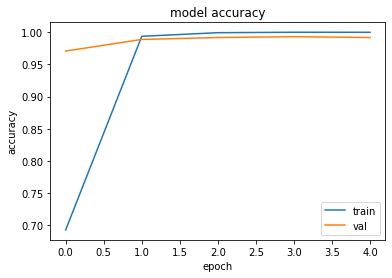

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

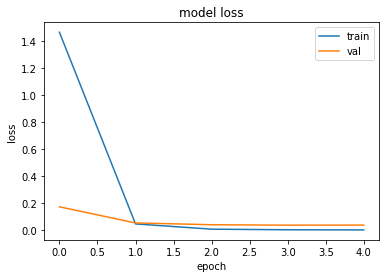

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#Prediction and Accuracy
 
Calculating the model accuracy based on f1, recall and precision measures with respect to test data


In [ ]:
yd_pred = classifier.predict(xd_test)
print(yd_pred[0,:])
yd_pred = (yd_pred > 0.5)
#print(yd_pred[0,:])

print(classification_report(yd_test,yd_pred))
score = f1_score(yd_test, yd_pred, average=None)
print("Training Score: ",score*100)
# Printing the accuracy of the model
print("The accuracy of the Deep Learning Model is: ", accuracy_score(yd_test, yd_pred)*100, "%")

[7.9891284e-04 5.7684656e-07 3.9393075e-07 1.1728422e-06 6.7212738e-08
 2.2289206e-09 2.6391632e-07 5.5313774e-07 3.0748666e-05 5.3905474e-08
 1.0462463e-07 4.2647925e-09 7.5858386e-09 7.1699395e-07 3.9825158e-04
 1.0481713e-08 1.4255136e-07 8.2472989e-06 6.6242711e-07 4.0449493e-08
 7.7425859e-05 9.7274379e-04 6.7816075e-07 2.9849218e-07 3.0824267e-05
 7.6786091e-04 2.0160388e-07 1.6113599e-07 2.8698486e-07 7.1268209e-07
 4.4769214e-07 3.1788682e-04 2.3050678e-08 5.6498305e-07 5.5025447e-07
 4.1473500e-06 6.9153195e-08 3.2799466e-07 2.3883769e-07 5.2472006e-07
 5.6403632e-08 9.6449441e-01 3.1585474e-02 4.5022948e-04 6.8761346e-07
 7.5642426e-08 3.8922090e-06 2.5342899e-07 7.3305365e-08 6.4553952e-08
 1.7326683e-07 1.3611196e-07 9.9666664e-08 2.5210343e-07 2.0780163e-07
 7.0221802e-07 2.4741860e-07 2.5617535e-05 2.0199592e-05 2.9148060e-07]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


At the end I would rather to use the NN over other algorithms, although Decision Tree is a faster model with slightly less accuracy 